In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.animation import FFMpegWriter
from pathlib import Path
from PIL import Image

from CreatePhasecontrastVideo import create_phase_contrast_video
from CreateResonantStack import create_res_maps
from Config import (root_path, expt_path, wave_initial, wave_final, wave_step)

Create phasecontrast video, return time-steps for each image so that a time-stamp can be included

In [2]:
t_interval = create_phase_contrast_video()

print(t_interval)
print(len(t_interval))

A Phasecontrast video already exists. Skipping creation.
[0.0, 0.10324707488218943, 0.20651697562800514, 0.3097663724422455, 0.413021175927586, 0.5161925921175214, 0.6193817163838281, 0.7225590970781114, 0.8257464284367032, 0.9289387760559717, 1.0321403144465553, 1.1353618284728793, 1.2386226387818655, 1.341876101228926, 1.445139974223243, 1.5484166691038344, 1.6517084259457058, 1.7550053446160423, 1.8583196904261907, 1.961641409198443, 2.0650452893972395, 2.1684838121467167, 2.271819236410989, 2.37519096924199, 2.4785906250609293, 2.5820033139652674, 2.6854672242535487, 2.788883107437028, 2.8923492895232306, 2.995819673670663, 3.0993165959914526, 3.202801010409991, 3.3062881354490914, 3.4097954611645807, 3.5132817604144413, 3.6168127829498715, 3.7203481225834953, 3.823877185848024, 3.9274207544326782, 4.030977246297731, 4.134540007710457, 4.2381387771500485, 4.341691190269258, 4.4452609475453695, 4.548795381320847, 4.6523626516924965, 4.755930076506402, 4.85950606405735, 4.96309672355

Check if processing has been started in the past, if it has load relevant filepaths.  If not generate new processing datafile.

In [12]:
try:
    dtypes = {
        'Filepath': 'string',
        'Processed': 'bool',
        'Result': 'string'
    }
    HyS_df = pd.read_csv(Path(root_path, expt_path, 'HyS_results.csv'), dtype=dtypes)
    print('HyS_results.csv found and loaded.')
except FileNotFoundError:
    root_len = len(Path(root_path).parts)
    HyS_path = Path(root_path, expt_path, 'Hyperspectral')

    HyS_data_paths = [Path(*p.parts[root_len:]).as_posix()
                        for p in HyS_path.iterdir()
                        if p.is_dir()]
    HyS_data_paths.sort(key=lambda x: int(x.stem))
    HyS_df = pd.DataFrame(HyS_data_paths,
                            columns=['Filepath'],
                            dtype='string')
    HyS_df['Processed'] = False
    HyS_df['Processed'] = HyS_df['Processed'].astype(bool)
    HyS_df['Result'] = 'None'
    HyS_df['Result'] = HyS_df['Result'].astype('string')
    HyS_df.to_csv(Path(root_path, expt_path, 'HyS_results.csv'), index=False)
    print('HyS_results.csv not found. Creating new file.')

print(HyS_df.head(2))

HyS_results.csv found and loaded.
                                       Filepath  Processed  \
0  MainExp\Phenospot\Location_1\Hyperspectral\1       True   
1  MainExp\Phenospot\Location_1\Hyperspectral\2       True   

                                              Result  
0  MainExp\Phenospot\Location_1\Hyperspectral\1\H...  
1  MainExp\Phenospot\Location_1\Hyperspectral\2\H...  


In [ ]:
temp_paths = list(Path(root_path, HyS_df['Filepath'][10]).glob('*.tiff'))
temp_paths.sort(key=lambda x: int(x.stem.split('_')[1]))
temp_path = temp_paths[10]
temp_im = Image.open(temp_path)
temp_im = np.asarray(temp_im)
temp_im = np.flipud(temp_im)
plt.title(f'.../{temp_path.parent.name}/{temp_path.stem}{temp_path.suffix}')
plt.imshow(temp_im)
plt.colorbar()

/Volumes/krauss/Lisa/Phenospot/Biofilms/Exp3/MainExp\Phenospot\Location_1\Hyperspectral\1


IndexError: list index out of range

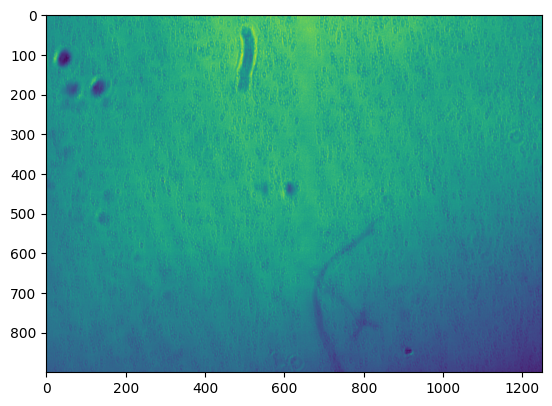

In [12]:
zoom_in_x = slice(250, 1500)
zoom_in_y = slice(100, 1000)
zoom_in = temp_im[zoom_in_y, zoom_in_x]
plt.imshow(zoom_in)

Generate list of 'wavelengths,' and confirm that it is the same length as the list of 'Hyperspectral' images

In [13]:
wav_ref = np.arange(wave_initial,
                    wave_final + wave_step/2,
                    wave_step)

assert len(wav_ref) == len(list(Path(root_path, HyS_df['Filepath'][10]).glob('*.tiff'))), 'Wavelength array must match the number of HyS images'
print(len(wav_ref))

51


Generate spectra from hyperspectral images (over specified areas of the image).

In [14]:
off_grating = list()
on_grating = list()
on_grating1 = list()
on_grating2 = list()
data_paths = list(Path(root_path, HyS_df['Filepath'][1]).glob('*.tiff'))
data_paths.sort(key=lambda x: int(x.stem.split('_')[1]))
for idx, HyS_im in enumerate(data_paths):
    im = Image.open(HyS_im)
    print(f'Imported image {idx+1} of {len(data_paths)}', end='\r')
    data = np.flipud(np.array(im))[0:100, 0:100].ravel()  # Off grating
    off_grating.append(np.mean(data))

    data = np.array(im)[600:700, 400:500].ravel()  # On grating
    on_grating.append(np.mean(data))
    data = np.array(im)[800:900, 1000:1100].ravel()  # On grating
    on_grating1.append(np.mean(data))
    data = np.array(im)[350:450, 1600:1700].ravel()  # On grating
    on_grating2.append(np.mean(data))

Standard deviation:
	On-grating: 851.86
	Off-grating: 10.18


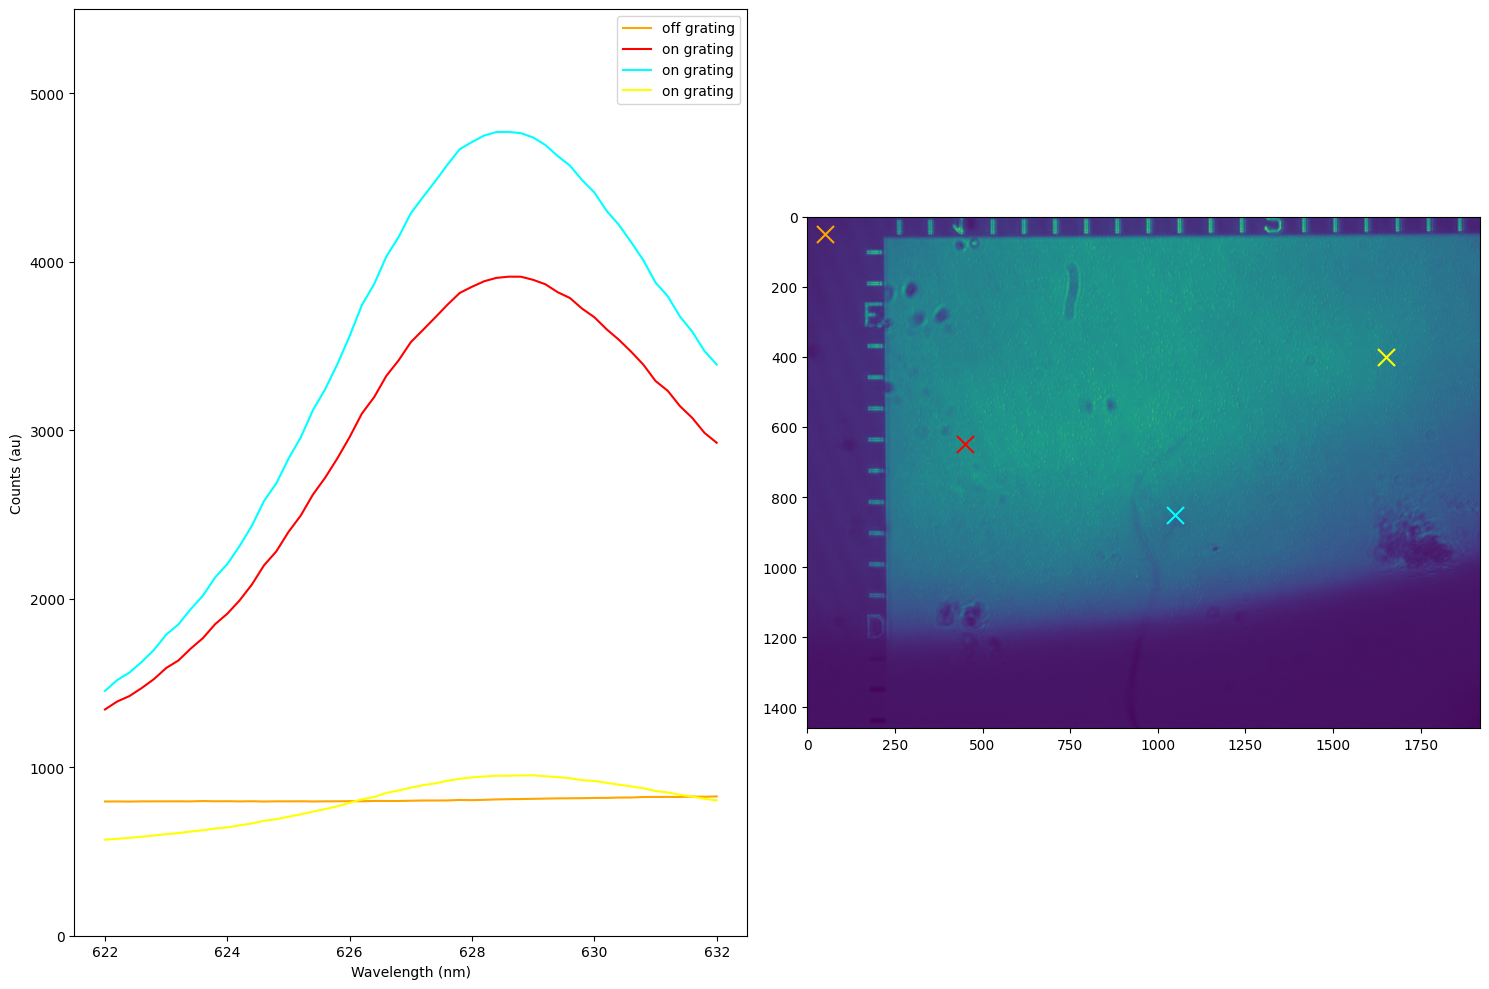

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), layout='tight')
ax1.plot(wav_ref, off_grating, color='orange', label='off grating')
ax1.plot(wav_ref, on_grating, color='red', label='on grating')
ax1.plot(wav_ref, on_grating1, color='cyan', label='on grating')
ax1.plot(wav_ref, on_grating2, color='yellow', label='on grating')
# ax1.vlines(wav_ref[np.argmax(off_grating)], 0, 10000, color='blue', alpha=0.5)
# ax1.vlines(wav_ref[np.argmax(on_grating)], 0, 10000, color='red', alpha=0.5)
ax1.set_ylim([0, 5500])
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Counts (au)')
ax1.legend()

ax2.imshow(np.flipud(np.array(im)))
ax2.scatter(50, 50, color='orange', marker='x', s=150)
ax2.scatter(450, 650, color='red', marker='x', s=150)
ax2.scatter(1050, 850, color='cyan', marker='x', s=150)
ax2.scatter(1650, 400, color='yellow', marker='x', s=150)

print('Standard deviation:')
print(f'\tOn-grating: {np.std(on_grating):.2f}')
print(f'\tOff-grating: {np.std(off_grating):.2f}')

Load all images in one 'Hyperspectral' directory and stack them into an numpy array.  Find location of maximum pixel value along axis 2 of the array.  Create hyperspectral image from the resonant wavelengths created above.  Multiply resulting image by 10 to maintain wavelength precision while converting to uint16.  Save resulting 16Bit image.

In [16]:
create_res_maps()

HyS_results.csv found and loaded.
All HyS data has been processed. Exiting...


Create list of Phase contrast image filepaths (needed in subsequent code blocks)

In [17]:
PhC_path = Path(root_path, expt_path, 'Phasecontrast')
PhC_data_paths = [p for p in PhC_path.glob('*.tiff')]
PhC_data_paths.sort(key=lambda x: int(x.stem.split('_')[0]))

print(PhC_data_paths[0])

/Volumes/krauss/Lisa/Phenospot/Biofilms/Experiment 1 - Test run 250121/2_biofilm_18h/Phasecontrast/1_Ph_Contr_image1.tiff


Calculate the average pixel value, over the entire hyperspectral image, and add value to list

In [18]:
avg_pixel_val = list()
for idx, HyS_fp in enumerate(HyS_df['Result']):
    im = Image.open(Path(root_path, HyS_fp))
    data = np.flipud(np.array(im))[zoom_in_y, zoom_in_x].ravel()
    # data = np.flipud(np.array(im))[:, :].ravel()
    avg_pixel_val.append(np.mean(data))
    print(f'Imported image {idx+1} of {len(HyS_df['Filepath'])}', end='\r')
    

Plot average pixel value against time - i.e. resonance shift over time.

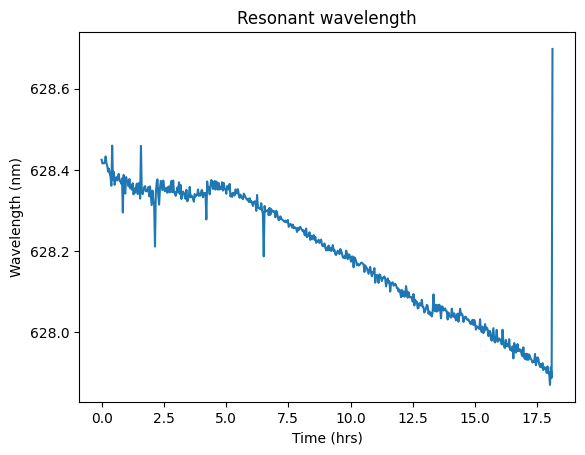

In [19]:
plt.plot(t_interval, [a/10 for a in avg_pixel_val])
# plt.ylim([622, 632])
plt.title('Resonant wavelength')
plt.xlabel('Time (hrs)')
plt.ylabel('Wavelength (nm)')
# plt.vlines(0, 685, 710, color='red', alpha=0.2)
plt.show()

Combine hyperspectral image, histogram of hyperspectral image resonant wavelengths, and resonant shift with time into one plot

Experiment 1 - Test run 250121/2_biofilm_18h/Hyperspectral/1/Hyperspectral_Image.png


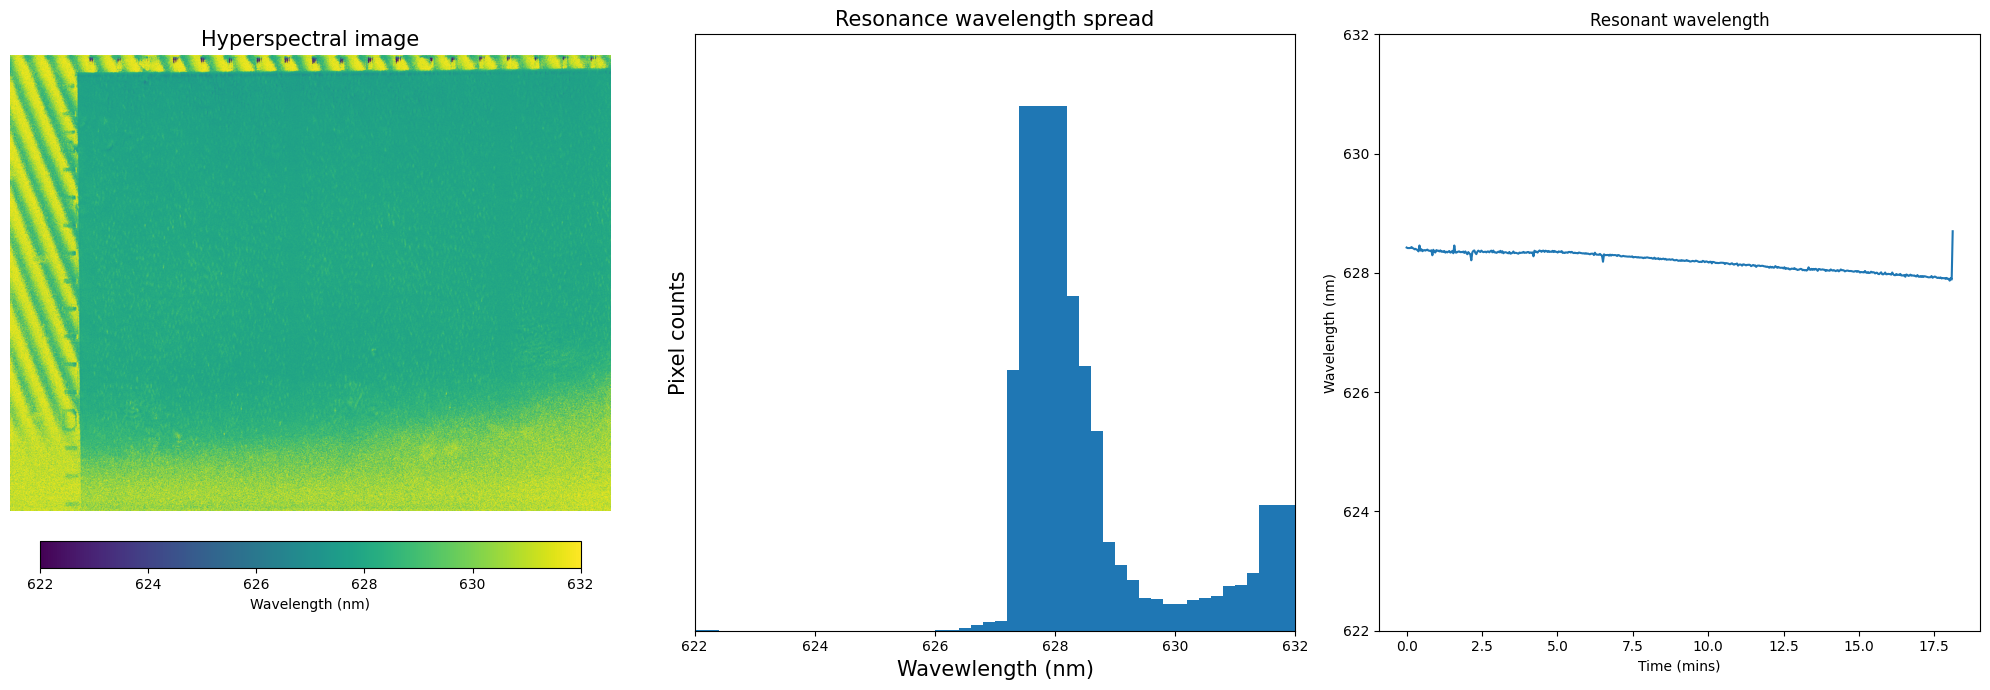

In [20]:
print(HyS_df['Result'][0])
in_image = Path(root_path, HyS_df['Result'].values[-1])
new_image = Image.open(in_image)
data = np.flipud(np.array(new_image)) / 10
histogram = np.histogram(data.ravel(), bins=int((632-622)/0.2))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,
                                    figsize=(20, 7), layout='tight')

im = ax1.imshow(data, aspect='equal', vmin=622, vmax=632)
colorbar = plt.colorbar(ax=ax1, mappable=im, shrink=0.9,
                        pad=0.05, orientation='horizontal',
                        label='Wavelength (nm)')
ax1.axis('off')
ax1.set_title('Hyperspectral image', fontsize=15)

ax2.bar(histogram[1][:-1], histogram[0])
ax2.set_xlim([622, 632])
ax2.set_ylim([0, 700_000])
ax2.set_yticks([])
ax2.set_title('Resonance wavelength spread', fontsize=15)
ax2.set_ylabel('Pixel counts', fontsize=15)
ax2.set_xlabel('Wavewlength (nm)', fontsize=15)

ax3.plot(t_interval, [a/10 for a in avg_pixel_val])
ax3.set_ylim([622, 632])
# ax3.set_xlim([0, 18.8])
ax3.set_title('Resonant wavelength')
ax3.set_xlabel('Time (mins)')
ax3.set_ylabel('Wavelength (nm)')
# ax3.vlines(0, 685, 710, color='red', alpha=0.2)

# plt.suptitle('Time:  XX mins', fontsize=20)
plt.show()

Combine phase contrast image, hypersectral image, histogram of hyperspectral image resonant wavelengths, and resonant shift with time into one plot and animate into a video with respect to time.

In [25]:
video_filename = Path(root_path, expt_path, f'Combined_Results_622-632.mp4')
wav_lo = 622
wav_hi = 632
writer = FFMpegWriter(fps=15)

PhC_image = np.array(Image.open(PhC_data_paths[0]))
PhC_image = np.flipud(PhC_image)
PhC_image = PhC_image - np.amin(PhC_image)
PhC_image = PhC_image / np.amax(PhC_image)

HyS_image_path = Path(root_path, HyS_df['Result'].values[0])
HyS_image = Image.open(HyS_image_path)
data = np.flipud(np.array(HyS_image)) / 10
histogram = np.histogram(data.ravel(), bins=int((wav_hi-wav_lo)/0.2))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
                                            figsize=(14, 14), layout='tight')
img_PhC = ax1.imshow(PhC_image, aspect='auto', cmap='gray', vmin=0, vmax=1)
ax1.axis('off')
ax1.set_title('Phase contrast image', fontsize=15)


img_HyS = ax2.imshow(data, aspect='auto', vmin=wav_lo, vmax=wav_hi)
cb_loc = ax2.inset_axes([0.1, 0.15, 0.8, 0.05])
cb = plt.colorbar(ax=ax2, mappable=img_HyS, shrink=0.5, cax=cb_loc,
                  pad=0.05, orientation='horizontal')
cb.ax.tick_params(color='white', labelcolor='white')
cb.set_label('Wavelength (nm)', color='white')
cb.outline.set_edgecolor('white')
ax2.axis('off')
ax2.set_title('Hyperspectral image', fontsize=15)

ax3.bar(histogram[1][:-1], histogram[0])
# ax3.set_xlim([wav_lo, wav_hi])
ax3.set_ylim([0, 700_000])
ax3.set_yticks([])
ax3.set_title('Resonance wavelength spread', fontsize=15)
ax3.set_ylabel('Pixel counts', fontsize=15)
ax3.set_xlabel('Wavewlength (nm)', fontsize=15)

ax4.plot(t_interval, [a/10 for a in avg_pixel_val])
ax4.set_ylim([wav_lo, wav_hi])
# ax4.set_xlim([0, 18.8])
ax4.set_title('Resonant wavelength')
ax4.set_xlabel('Time (mins)')
ax4.set_ylabel('Wavelength (nm)')
# ax4.vlines(0, 685, 695, color='red', alpha=0.2)

t = 0
message = 'Time:  {:0.1f} hrs'
plt.suptitle(message.format(t), fontsize=20)

with writer.saving(fig, video_filename, dpi=100):
    for idx, (t, HyS_fp, PhC_fp) in enumerate(zip(t_interval,
                                                  HyS_df['Result'],
                                                  PhC_data_paths)):
        PhC_image = np.array(Image.open(Path(PhC_fp)))
        PhC_image = PhC_image - np.amin(PhC_image)
        PhC_image = PhC_image / np.amax(PhC_image)

        HyS_image_path = Path(root_path, HyS_fp)
        HyS_image = Image.open(HyS_image_path)
        HyS_image = np.array(HyS_image) / 10
        histogram = np.histogram(
            HyS_image.ravel(), bins=int((wav_hi-wav_lo)/0.2))
        plt.suptitle(message.format(t), fontsize=20)

        img_PhC.set_data(PhC_image)
        img_HyS.set_data(HyS_image)
        ax3.clear()
        ax3.bar(histogram[1][:-1], histogram[0])
        # ax3.vlines(wav_lo, 0, 400000, color='red', alpha=0.2)
        # ax3.vlines(wav_hi, 0, 400000, color='red', alpha=0.2)
        # ax3.set_xlim([685, 695])
        ax3.set_ylim([0, 700_000])
        ax3.set_yticks([])
        ax3.set_title('Resonance wavelength spread', fontsize=15)
        ax3.set_ylabel('Pixel counts', fontsize=15)
        ax3.set_xlabel('Wavewlength (nm)', fontsize=15)

        ax4.clear()
        ax4.plot(t_interval, [a/10 for a in avg_pixel_val])
        ax4.vlines(t, wav_lo, wav_hi, color='red', alpha=0.2)
        ax4.set_ylim([wav_lo, wav_hi])
        # ax4.set_xlim([0, 18.8]) 
        ax4.set_title('Resonant wavelength')
        ax4.set_xlabel('Time (mins)')
        ax4.set_ylabel('Wavelength (nm)')

        writer.grab_frame()
        print(f'Frame {idx + 1} of {len(HyS_df['Result'])} written', end='\r')
plt.close(fig)